In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
domestic_df = pd.read_csv("domestic_city_processed.csv")
international_df = pd.read_csv("international_city_cleaned.csv")

# Add/ensure traffic type column (in case domestic one doesn't have)
if 'traffic_type' not in domestic_df.columns:
    domestic_df['traffic_type'] = 'domestic'
if 'traffic_type' not in international_df.columns:
    international_df['traffic_type'] = 'international'

# Basic check
print("Domestic shape:", domestic_df.shape)
print("International shape:", international_df.shape)


Domestic shape: (56047, 24)
International shape: (14538, 21)


In [37]:
domestic_df

,year,month,city1,city2,paxtocity2,paxfromcity2,freighttocity2,freightfromcity2,mailtocity2,mailfromcity2,...,freighttocity2_scaled,freightfromcity2_scaled,mailtocity2_scaled,mailfromcity2_scaled,total_passengers,total_freight,total_mail,pax_growth_pct,traffic_type,period
0,2021,12,ADAMPUR,AHMEDABAD,30.0,0.0,0.00,0.00,0.0,0.00,...,-0.211484,-0.196652,-0.285652,-0.249218,30.0,0.00,0.00,NaN,domestic,1970-03-31 23:59:59.999999999
1,2018,5,ADAMPUR,DELHI,2258.0,2190.0,0.00,0.86,0.0,0.00,...,-0.211484,-0.192234,-0.285652,-0.249218,4448.0,0.86,0.00,NaN,domestic,1970-03-31 23:59:59.999999999
2,2018,6,ADAMPUR,DELHI,1984.0,1981.0,0.00,4.33,0.0,0.00,...,-0.211484,-0.174409,-0.285652,-0.249218,3965.0,4.33,0.00,-10.858813,domestic,1970-03-31 23:59:59.999999999
3,2018,7,ADAMPUR,DELHI,2333.0,2205.0,0.00,1.93,0.0,0.00,...,-0.211484,-0.186738,-0.285652,-0.249218,4538.0,1.93,0.00,14.451450,domestic,1970-03-31 23:59:59.999999999
4,2018,8,ADAMPUR,DELHI,2146.0,1981.0,0.00,0.48,0.0,0.00,...,-0.211484,-0.194186,-0.285652,-0.249218,4127.0,0.48,0.00,-9.056853,domestic,1970-03-31 23:59:59.999999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56042,2025,2,VIJAYAWADA,VISAKHAPATNAM,5510.0,5304.0,0.00,0.12,0.0,0.80,...,-0.211484,-0.196035,-0.285652,-0.144607,10814.0,0.12,0.80,-11.657544,domestic,1970-03-31 23:59:59.999999999
56043,2025,3,VIJAYAWADA,VISAKHAPATNAM,6011.0,5003.0,0.01,0.18,0.0,1.99,...,-0.211434,-0.195727,-0.285652,0.011002,11014.0,0.19,1.99,1.849454,domestic,1970-03-31 23:59:59.999999999
56044,2022,10,ZERO AIRPORT,DIBRUGARH,4.0,1.0,0.00,0.00,0.0,0.00,...,-0.211484,-0.196652,-0.285652,-0.249218,5.0,0.00,0.00,NaN,domestic,1970-03-31 23:59:59.999999999
56045,2022,11,ZIRO,DIBRUGARH,4.0,8.0,0.00,0.00,0.0,0.00,...,-0.211484,-0.196652,-0.285652,-0.249218,12.0,0.00,0.00,NaN,domestic,1970-03-31 23:59:59.999999999


In [28]:
import re
import numpy as np
import pandas as pd

def _normalize_year(series, low=1990, high=2100):
    s = series.astype(str)

    # Try to pull a 4-digit year
    y4 = s.str.extract(r'(\d{4})', expand=False)

    # Fallback: 2-digit year → map to 2000s
    y2 = s.str.extract(r'\b(\d{2})\b', expand=False)

    year = pd.to_numeric(y4, errors='coerce')

    if year.isna().any():
        y2_num = pd.to_numeric(y2, errors='coerce')
        y2_mapped = np.where(y2_num.notna(), 2000 + y2_num, np.nan)
        y2_mapped = pd.Series(y2_mapped, index=series.index)
        year = year.fillna(y2_mapped)

    year = pd.to_numeric(year, errors='coerce')
    return year.where((year >= low) & (year <= high))

def _normalize_quarter(series):
    # Always return a pandas Series aligned with input index
    s = series.astype(str).str.upper().str.strip()

    # Case 1: plain numbers "1","2","03","4"
    qnum = pd.to_numeric(s, errors='coerce')

    # Case 2: patterns with Q like "Q2", "2023-Q3", "Q4 2021"
    q_from_str = s.str.extract(r'Q\s*([1-4])', expand=False)
    q_from_str = pd.to_numeric(q_from_str, errors='coerce')

    # Prefer valid numeric, else use extracted
    q = qnum.where(qnum.isin([1,2,3,4]), q_from_str)
    return q.where(q.isin([1,2,3,4]))

def build_quarter_period(df, quarter_col='quarter', year_col='year', how='end'):
    q = _normalize_quarter(df[quarter_col])

    # Year from explicit column if present, else from the quarter text
    if year_col in df.columns:
        y = pd.to_numeric(df[year_col], errors='coerce')
        # fix 2-digit years in explicit col (e.g., 20 → 2020)
        y = pd.Series(np.where((y >= 0) & (y <= 99), 2000 + y, y), index=df.index)
        y_from_text = _normalize_year(df[quarter_col])
        year_final = y.where(y.notna(), y_from_text)
    else:
        year_final = _normalize_year(df[quarter_col])

    # Sanity bounds
    year_final = pd.to_numeric(year_final, errors='coerce').where((year_final >= 1990) & (year_final <= 2100))

    ok = q.notna() & year_final.notna()
    period = pd.Series(pd.NaT, index=df.index, dtype='datetime64[ns]')

    if ok.any():
        q_ok = q[ok].astype('Int64')
        y_ok = year_final[ok].astype('Int64')

        try:
            pi = pd.PeriodIndex(year=y_ok, quarter=q_ok, freq='Q')
            period.loc[ok] = pi.to_timestamp(how=how)
        except Exception:
            # Row-wise fallback (very safe)
            def mk_ts(yv, qv):
                try:
                    return pd.Period(f'{int(yv)}Q{int(qv)}', freq='Q').to_timestamp(how=how)
                except Exception:
                    return pd.NaT
            period.loc[ok] = [mk_ts(yv, qv) for yv, qv in zip(y_ok, q_ok)]

    return period


In [29]:
international_df['period'] = build_quarter_period(
    international_df,
    quarter_col='quarter',
    year_col='year',  # OK if missing; function handles it
    how='end'         # or 'start' if you prefer quarter start dates
)


C:\Users\HP\AppData\Local\Temp\ipykernel_12088\3457168176.py:64: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  pi = pd.PeriodIndex(year=y_ok, quarter=q_ok, freq='Q')


In [30]:
print(international_df[['year','quarter','period']].head(12))
print("Unparsed rows:", international_df['period'].isna().sum())


    year  quarter                        period
0     20        2 2020-06-30 23:59:59.999999999
1     20        3 2020-09-30 23:59:59.999999999
2     15        1 2015-03-31 23:59:59.999999999
3     15        2 2015-06-30 23:59:59.999999999
4     15        3 2015-09-30 23:59:59.999999999
5     15        4 2015-12-31 23:59:59.999999999
6     16        1 2016-03-31 23:59:59.999999999
7     16        2 2016-06-30 23:59:59.999999999
8     16        3 2016-09-30 23:59:59.999999999
9     16        4 2016-12-31 23:59:59.999999999
10    17        1 2017-03-31 23:59:59.999999999
11    17        2 2017-06-30 23:59:59.999999999
Unparsed rows: 0


In [38]:
import pandas as pd
import numpy as np

# Load if needed
try:
    domestic_df
except NameError:
    domestic_df = pd.read_csv("domestic_city_processed.csv")

# Ensure numeric year and month
domestic_df['year'] = pd.to_numeric(domestic_df['year'], errors='coerce')
domestic_df['month'] = pd.to_numeric(domestic_df['month'], errors='coerce')

# ✅ Build proper datetime column safely
domestic_df['period'] = pd.to_datetime(
    domestic_df[['year', 'month']].assign(day=1),
    errors='coerce'
)

print("✅ Period sample after conversion:")
print(domestic_df[['year','month','period']].head())
# Convert to quarter-end timestamps
domestic_df['period'] = domestic_df['period'].dt.to_period('Q').dt.to_timestamp(how='end')

# Aggregate by city pair and period
domestic_quarterly = (
    domestic_df
    .groupby(['city1','city2','period'], dropna=False)
    .agg({
        'paxtocity2':'sum',
        'paxfromcity2':'sum',
        'freighttocity2':'sum',
        'freightfromcity2':'sum',
        'mailtocity2':'sum',
        'mailfromcity2':'sum'
    })
    .reset_index()
)

# Add totals
domestic_quarterly['total_passengers'] = domestic_quarterly['paxtocity2'].fillna(0) + domestic_quarterly['paxfromcity2'].fillna(0)
domestic_quarterly['total_freight'] = domestic_quarterly['freighttocity2'].fillna(0) + domestic_quarterly['freightfromcity2'].fillna(0)
domestic_quarterly['total_mail'] = domestic_quarterly['mailtocity2'].fillna(0) + domestic_quarterly['mailfromcity2'].fillna(0)
domestic_quarterly['traffic_type'] = 'domestic'

print("✅ Domestic quarterly data ready!")
print(domestic_quarterly[['city1','city2','period']].head(10))


✅ Period sample after conversion:
   year  month     period
0  2021     12 2021-12-01
1  2018      5 2018-05-01
2  2018      6 2018-06-01
3  2018      7 2018-07-01
4  2018      8 2018-08-01
✅ Domestic quarterly data ready!
     city1      city2                        period
0  ADAMPUR  AHMEDABAD 2021-12-31 23:59:59.999999999
1  ADAMPUR      DELHI 2018-06-30 23:59:59.999999999
2  ADAMPUR      DELHI 2018-09-30 23:59:59.999999999
3  ADAMPUR      DELHI 2018-12-31 23:59:59.999999999
4  ADAMPUR      DELHI 2019-03-31 23:59:59.999999999
5  ADAMPUR      DELHI 2019-06-30 23:59:59.999999999
6  ADAMPUR      DELHI 2019-09-30 23:59:59.999999999
7  ADAMPUR      DELHI 2019-12-31 23:59:59.999999999
8  ADAMPUR      DELHI 2020-03-31 23:59:59.999999999
9  ADAMPUR      DELHI 2020-06-30 23:59:59.999999999


In [39]:
combined_df = pd.concat([domestic_quarterly, international_df], ignore_index=True)


In [40]:
combined_df

,city1,city2,period,paxtocity2,paxfromcity2,freighttocity2,freightfromcity2,mailtocity2,mailfromcity2,total_passengers,total_freight,total_mail,traffic_type
0,ADAMPUR,AHMEDABAD,2021-12-31 23:59:59.999999999,30.0,0.0,0.00,0.00,0.0,0.0,30.0,0.00,0.0,domestic
1,ADAMPUR,DELHI,2018-06-30 23:59:59.999999999,4242.0,4171.0,0.00,5.19,0.0,0.0,8413.0,5.19,0.0,domestic
2,ADAMPUR,DELHI,2018-09-30 23:59:59.999999999,6716.0,6350.0,0.00,3.02,0.0,0.0,13066.0,3.02,0.0,domestic
3,ADAMPUR,DELHI,2018-12-31 23:59:59.999999999,6874.0,6860.0,0.00,5.48,0.0,0.0,13734.0,5.48,0.0,domestic
4,ADAMPUR,DELHI,2019-03-31 23:59:59.999999999,6737.0,6707.0,0.00,2.14,0.0,0.0,13444.0,2.14,0.0,domestic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35632,ZURICH,MUMBAI,2024-06-30 23:59:59.999999999,15949.0,20470.0,1049.75,1500.75,NaN,NaN,36419.0,2550.50,NaN,international
35633,ZURICH,MUMBAI,2024-09-30 23:59:59.999999999,17199.0,20409.0,1123.27,1458.84,NaN,NaN,37608.0,2582.11,NaN,international
35634,ZURICH,MUMBAI,2024-12-31 23:59:59.999999999,19912.0,18611.0,1173.06,1329.66,NaN,NaN,38523.0,2502.72,NaN,international
35635,ZURICH,MUMBAI,2025-03-31 23:59:59.999999999,12059.0,19149.0,1084.37,1209.82,NaN,NaN,31208.0,2294.19,NaN,international


    traffic_type  total_passengers
0       domestic      1.170546e+09
1  international      5.457101e+08


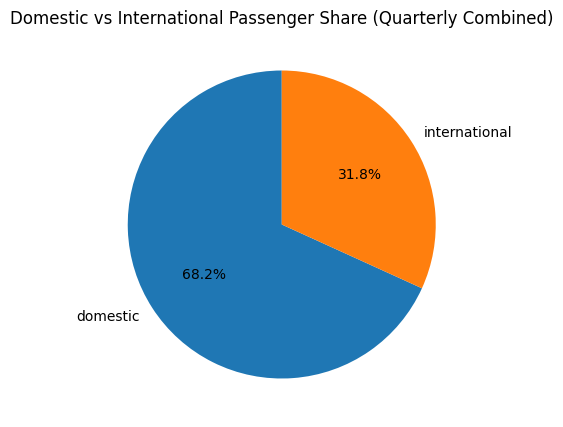

In [41]:
traffic_split = (
    combined_df.groupby('traffic_type', dropna=False)['total_passengers']
    .sum()
    .reset_index()
    .sort_values('total_passengers', ascending=False)
)
print(traffic_split)

plt.figure(figsize=(5,5))
plt.pie(traffic_split['total_passengers'],
        labels=traffic_split['traffic_type'],
        autopct='%1.1f%%', startangle=90)
plt.title('Domestic vs International Passenger Share (Quarterly Combined)')
plt.show()


In [43]:
import pandas as pd

# If you just created combined_df
# or loaded from "combined_city_traffic_quarterly.csv"
try:
    combined_df
except NameError:
    combined_df = pd.read_csv("combined_city_traffic_quarterly.csv", parse_dates=['period'])

# ✅ Add year extracted from period
combined_df['year'] = combined_df['period'].dt.year

# Optional: confirm
print(combined_df[['period', 'year', 'traffic_type']].head(10))
print("Unique years:", sorted(combined_df['year'].dropna().unique().tolist()))


                         period  year traffic_type
0 2021-12-31 23:59:59.999999999  2021     domestic
1 2018-06-30 23:59:59.999999999  2018     domestic
2 2018-09-30 23:59:59.999999999  2018     domestic
3 2018-12-31 23:59:59.999999999  2018     domestic
4 2019-03-31 23:59:59.999999999  2019     domestic
5 2019-06-30 23:59:59.999999999  2019     domestic
6 2019-09-30 23:59:59.999999999  2019     domestic
7 2019-12-31 23:59:59.999999999  2019     domestic
8 2020-03-31 23:59:59.999999999  2020     domestic
9 2020-06-30 23:59:59.999999999  2020     domestic
Unique years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]


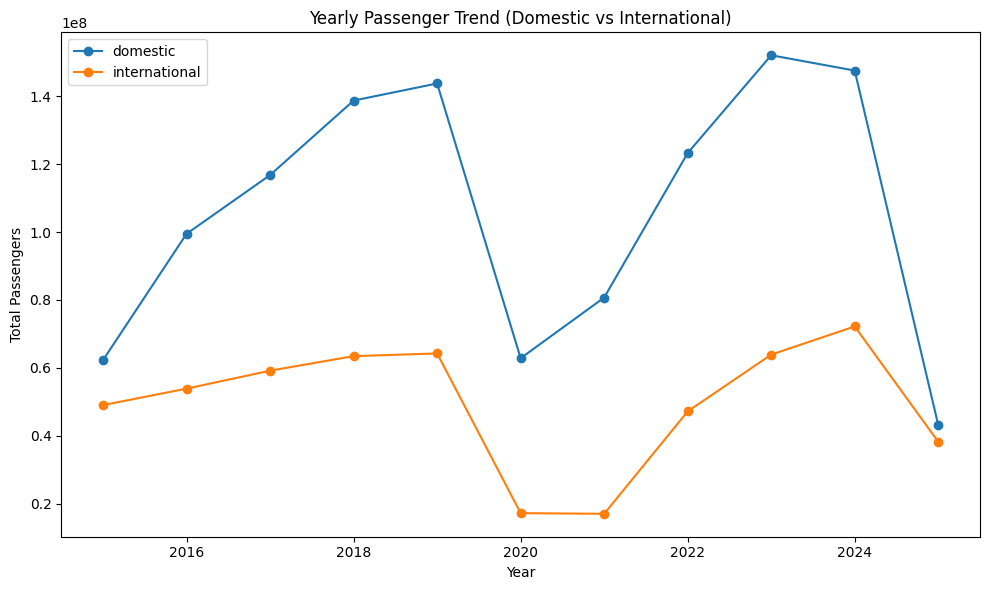

In [44]:
yearly = (combined_df
          .groupby(['year','traffic_type'], dropna=False)['total_passengers']
          .sum()
          .reset_index()
          .sort_values(['year','traffic_type']))

plt.figure(figsize=(10,6))
for t in yearly['traffic_type'].unique():
    sub = yearly[yearly['traffic_type']==t]
    plt.plot(sub['year'], sub['total_passengers'], marker='o', label=t)

plt.title('Yearly Passenger Trend (Domestic vs International)')
plt.xlabel('Year'); plt.ylabel('Total Passengers'); plt.legend()
plt.tight_layout(); plt.show()


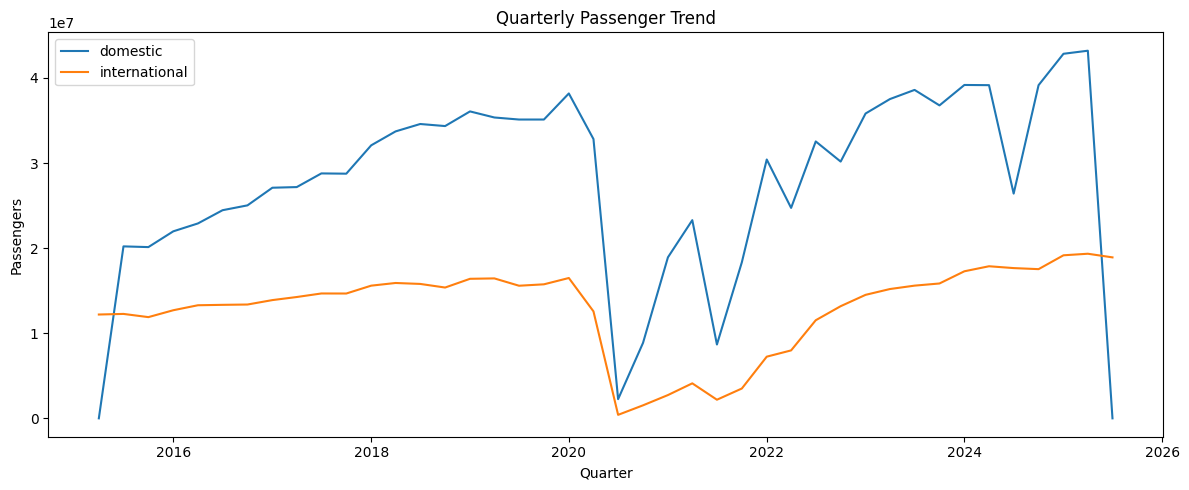

In [45]:
quarterly = (combined_df
             .groupby(['period','traffic_type'], dropna=False)['total_passengers']
             .sum()
             .reset_index()
             .pivot(index='period', columns='traffic_type', values='total_passengers')
             .fillna(0)
            )

plt.figure(figsize=(12,5))
plt.plot(quarterly.index, quarterly.get('domestic', 0), label='domestic')
plt.plot(quarterly.index, quarterly.get('international', 0), label='international')
plt.title('Quarterly Passenger Trend')
plt.xlabel('Quarter'); plt.ylabel('Passengers'); plt.legend()
plt.tight_layout(); plt.show()


                   route  total_passengers
434    BENGALURU → DELHI        37468355.0
2182      MUMBAI → DELHI        32629461.0
470   BENGALURU → MUMBAI        31791771.0
972    DELHI → HYDERABAD        24142823.0
1000      DELHI → MUMBAI        24061209.0
1011        DELHI → PUNE        22221613.0
1186      DUBAI → MUMBAI        20965013.0
117    AHMEDABAD → DELHI        18695972.0
1170       DUBAI → DELHI        18377141.0
1021    DELHI → SRINAGAR        17941599.0


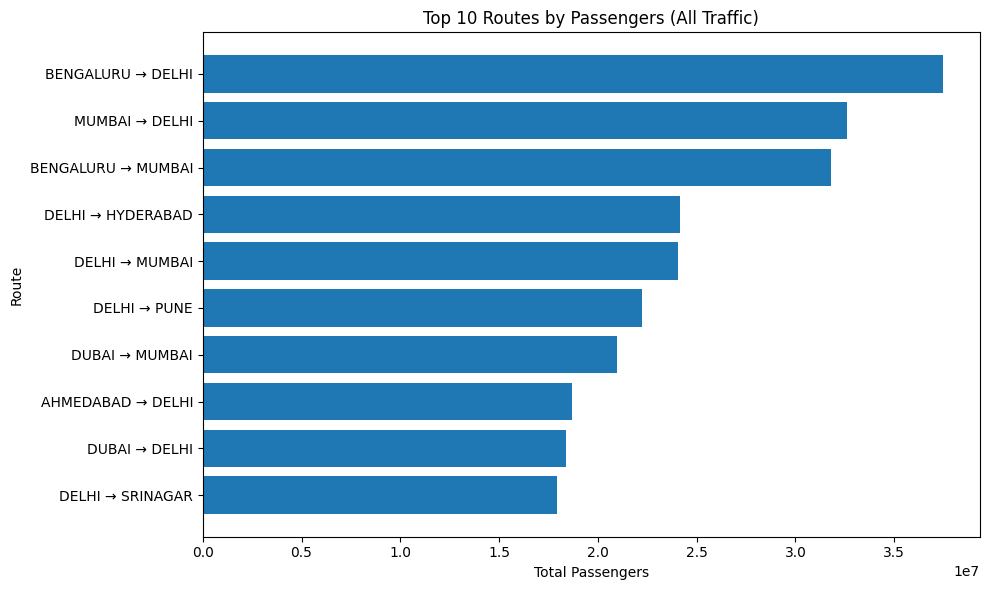

In [46]:
routes = (combined_df
          .groupby(['city1','city2'], dropna=False)['total_passengers']
          .sum()
          .reset_index()
          .sort_values('total_passengers', ascending=False)
         )
top_routes = routes.head(10).copy()
top_routes['route'] = top_routes['city1'] + " → " + top_routes['city2']
print(top_routes[['route','total_passengers']])

plt.figure(figsize=(10,6))
plt.barh(top_routes['route'][::-1], top_routes['total_passengers'][::-1])
plt.title('Top 10 Routes by Passengers (All Traffic)')
plt.xlabel('Total Passengers'); plt.ylabel('Route')
plt.tight_layout(); plt.show()


          city        total
92       DELHI  584059238.0
237     MUMBAI  411097662.0
48   BENGALURU  268405823.0
141  HYDERABAD  189049688.0
71     CHENNAI  175873174.0
184    KOLKATA  169590057.0
105      DUBAI  105020816.0
10   AHMEDABAD   89078550.0
182      KOCHI   84013781.0
282       PUNE   71786334.0


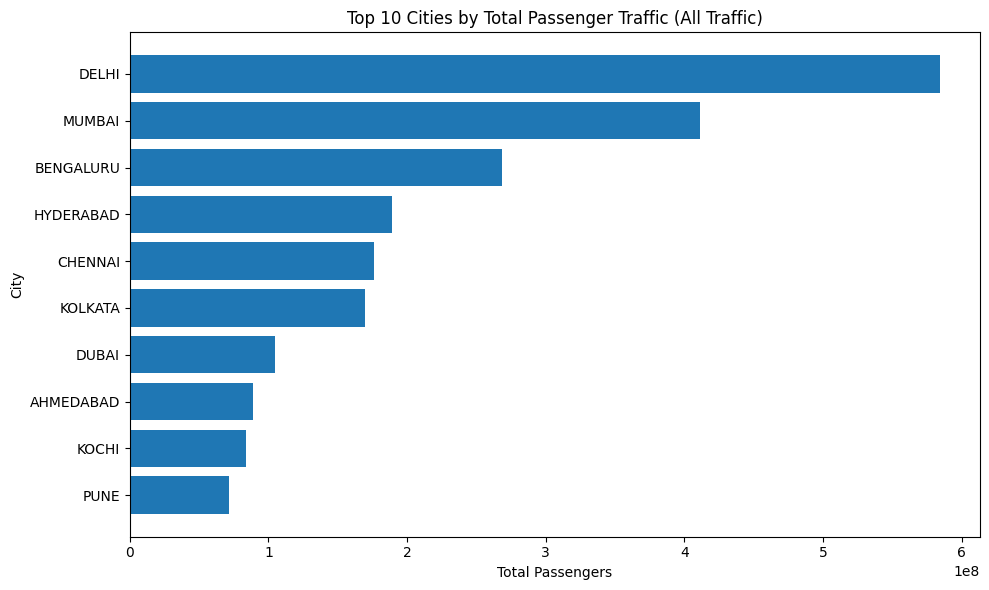

In [47]:
city_from = (combined_df.groupby('city1', dropna=False)['total_passengers']
             .sum().rename('from_total'))
city_to   = (combined_df.groupby('city2', dropna=False)['total_passengers']
             .sum().rename('to_total'))

city_totals = (city_from.to_frame()
               .join(city_to, how='outer')
               .fillna(0)
               .assign(total=lambda x: x['from_total'] + x['to_total'])
               .reset_index().rename(columns={'index':'city'}))

top_cities = city_totals.sort_values('total', ascending=False).head(10)
print(top_cities[['city','total']])

plt.figure(figsize=(10,6))
plt.barh(top_cities['city'][::-1], top_cities['total'][::-1])
plt.title('Top 10 Cities by Total Passenger Traffic (All Traffic)')
plt.xlabel('Total Passengers'); plt.ylabel('City')
plt.tight_layout(); plt.show()


                            period      city1    city2  total_passengers  rank
110  2015-03-31 23:59:59.999999999      DUBAI   MUMBAI          560144.0   1.0
100  2015-03-31 23:59:59.999999999      DUBAI    DELHI          436924.0   2.0
180  2015-03-31 23:59:59.999999999     LONDON    DELHI          244855.0   3.0
99   2015-03-31 23:59:59.999999999      DUBAI  CHENNAI          220293.0   4.0
104  2015-03-31 23:59:59.999999999      DUBAI    KOCHI          214754.0   5.0
748  2015-06-30 23:59:59.999999999     MUMBAI    DELHI         1485463.0   1.0
399  2015-06-30 23:59:59.999999999  BENGALURU   MUMBAI          804805.0   2.0
383  2015-06-30 23:59:59.999999999  BENGALURU    DELHI          764098.0   3.0
553  2015-06-30 23:59:59.999999999      DUBAI   MUMBAI          534851.0   4.0
336  2015-06-30 23:59:59.999999999  AHMEDABAD   MUMBAI          517888.0   5.0
1375 2015-09-30 23:59:59.999999999     MUMBAI    DELHI         1412761.0   1.0
981  2015-09-30 23:59:59.999999999  BENGALURU    DEL

C:\Users\HP\AppData\Local\Temp\ipykernel_12088\2687697581.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp['route'] = samp['city1'] + " → " + samp['city2']


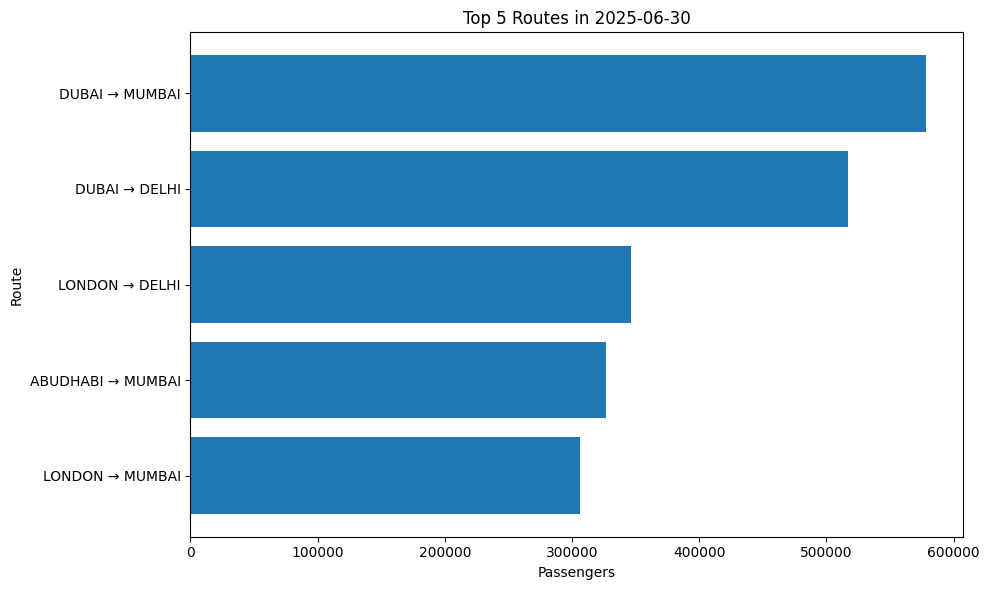

In [48]:
# Choose N
N = 5

# Aggregate per quarter & route
qr = (combined_df
      .groupby(['period','city1','city2'], dropna=False)['total_passengers']
      .sum()
      .reset_index())

# Rank within each quarter
qr['rank'] = qr.groupby('period')['total_passengers'].rank(method='first', ascending=False)

top_by_quarter = qr[qr['rank'] <= N].sort_values(['period','rank'])
print(top_by_quarter.head(25))

# (Optional) Show for a specific quarter
if not top_by_quarter.empty:
    sample_q = top_by_quarter['period'].max()
    samp = top_by_quarter[top_by_quarter['period']==sample_q]
    samp['route'] = samp['city1'] + " → " + samp['city2']

    plt.figure(figsize=(10,6))
    plt.barh(samp['route'][::-1], samp['total_passengers'][::-1])
    plt.title(f'Top {N} Routes in {sample_q.date()}')
    plt.xlabel('Passengers'); plt.ylabel('Route')
    plt.tight_layout(); plt.show()
